# Imminent ICU Admission and Prolonged Stay Prediction using Gradient Boosting Machines

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import numpy as np
np.set_printoptions(precision=2)

import pandas as pd
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
import lightgbm

from utils.splits import set_group_splits
from utils.metrics import BinaryAvgMetrics, get_best_model
from utils.plots import *
from args import args
vars(args)

{'workdir': PosixPath('../data/workdir/gbm'),
 'dataset_csv': PosixPath('../data/proc_dataset.csv'),
 'cols': ['hadm_id',
  'imminent_adm_label',
  'prolonged_stay_label',
  'processed_note',
  'charttime',
  'intime'],
 'imminent_adm_cols': ['hadm_id', 'processed_note', 'imminent_adm_label'],
 'prolonged_stay_cols': ['hadm_id', 'processed_note', 'prolonged_stay_label'],
 'dates': ['charttime', 'intime'],
 'modeldir': PosixPath('../data/workdir/gbm/models'),
 'min_freq': 3,
 'ia_thresh': 0.526,
 'ps_thresh': 0.45,
 'start_seed': 127}

## GBM Dev

In [3]:
seed = None
ori_df = pd.read_csv(args.dataset_csv, usecols=args.cols, parse_dates=args.dates)
ia_df = ori_df.loc[(ori_df['imminent_adm_label'] != -1)][args.imminent_adm_cols].reset_index(drop=True)
ps_df = ori_df[args.prolonged_stay_cols].copy()

print(ia_df.shape)
print(ps_df.shape)

(50809, 3)
(75271, 3)


### Predict Imminent ICU Admission

In [4]:
df = set_group_splits(ia_df.copy(), group_col='hadm_id', seed=seed)
vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2))
x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['processed_note'])
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['processed_note'])
y_train = df.loc[(df['split'] == 'train')]['imminent_adm_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['imminent_adm_label'].to_numpy()
df.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50809, 4), (42717, 55724), (8092, 55724), (42717,), (8092,))

In [5]:
params = {
  "objective": "binary",
  "metric": "binary_logloss",
  "bagging_fraction": 0.413,
  "bagging_freq": 20,
  "boosting": "dart",
  "feature_fraction": 0.288,
  "is_unbalance": True,
  "lambda_l1": 3.367,
  "learning_rate": 0.037,
  "max_bin": 9,
  "min_data_in_leaf": 12,
  "num_iterations": 163,
  "num_leaves": 45
}

In [6]:
params = {
  "objective": "binary",
  "metric": "binary_logloss",
  "bagging_fraction": 0.5,
  "bagging_freq": 5,
  "boosting": "gbdt",
  "feature_fraction": 0.5,
  "is_unbalance": True,
#   "lambda_l1": 3.0,
  "learning_rate": 0.1,
#   "max_bin": 9,
  "min_data_in_leaf": 3,
  "num_iterations": 150,
  "num_leaves": 50,
}

In [7]:
clf = lightgbm.LGBMClassifier(**params, n_threads=32)
clf.fit(x_train, y_train)
prob = clf.predict_proba(x_test)[:, 1]

/net/vaosl01/opt/NFS/su0/anaconda3/envs/icu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


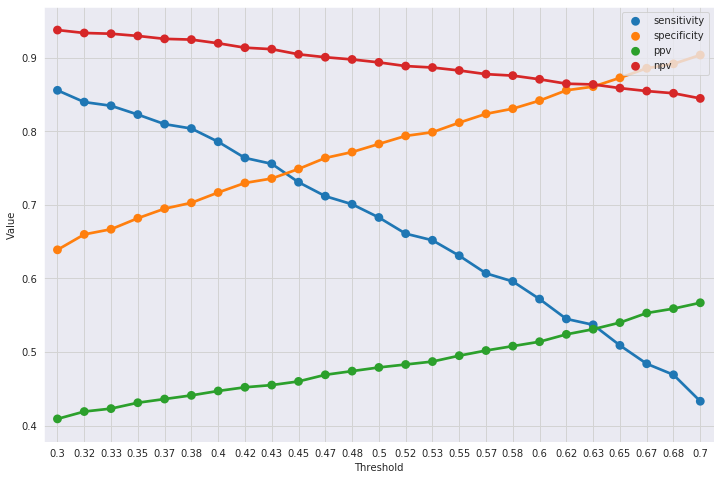

In [8]:
fig, ax = plt.subplots(figsize=(12,8))
plot_thresh_range(ax, y_test, prob, 0.3, 0.7, 25)

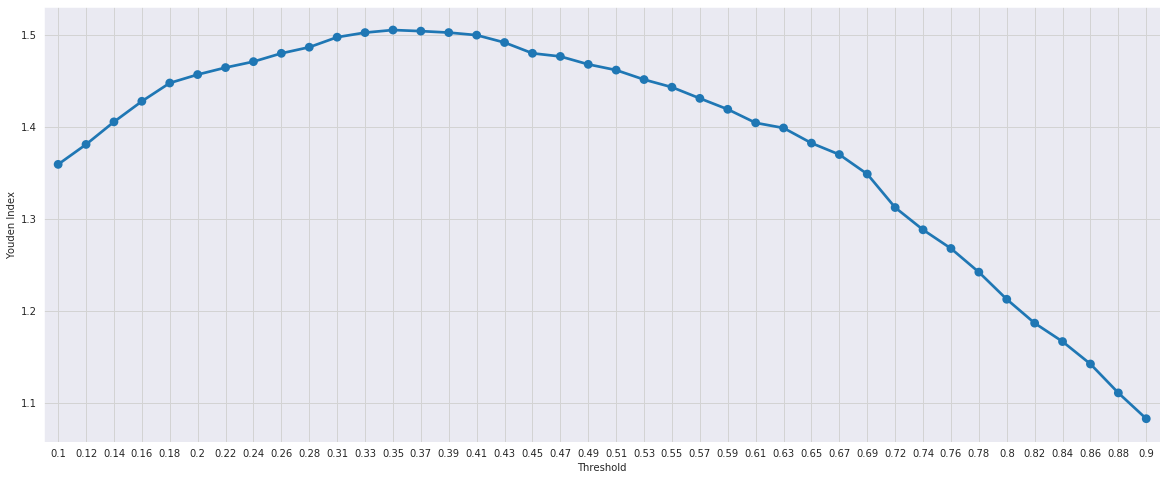

In [9]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_youden(ax, y_test, prob, 0.1, 0.9, 40)

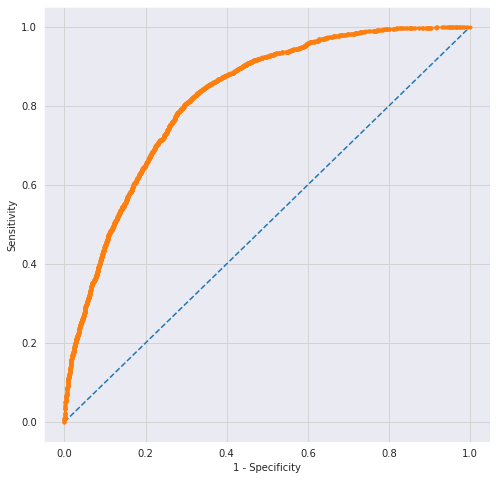

In [10]:
fig, ax = plt.subplots(figsize=(8,8))
plot_roc(ax, y_test, prob)

In [11]:
args.imminent_threshold = 0.35
y_pred = (prob > args.imminent_threshold).astype(np.int64)
cm = confusion_matrix(y_test, y_pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
}

metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.823
specificity,0.682
ppv,0.431
npv,0.930
f1,0.566
auroc,0.820


In [ ]:
targs, preds, probs = [], [], []
task = 'imminent_adm'
task_df = ia_df

for seed in range(127, 227):
  df = set_group_splits(task_df.copy(), group_col='hadm_id', seed=seed)
  vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, ngram_range=(2,2))

  x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['processed_note'])
  x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['processed_note'])

  y_train = df.loc[(df['split'] == 'train')][f'{task}_label'].to_numpy()
  targ = df.loc[(df['split'] == 'test')][f'{task}_label'].to_numpy()

  with open(args.modeldir/f'{task}_seed_{seed}.pkl', 'rb') as f:
    clf = pickle.load(f)

  pos_prob = clf.predict_proba(x_test)[:, 1]
  y_pred = (pos_prob > args.ia_thresh).astype(np.int64)

  targs.append(targ)
  preds.append(y_pred)
  probs.append(pos_prob)

In [ ]:
with open(args.workdir/f'{task}_preds.pkl', 'wb') as f:
  pickle.dump(targs, f)
  pickle.dump(preds, f)
  pickle.dump(probs, f)

In [ ]:
args.ia_thresh

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(ax, cm, classes=['Delayed', 'Imminent'], normalize=False, title='Confusion matrix')

In [ ]:
scores = clf.feature_importances_ / clf.feature_importances_.sum()

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
neg_cloud, pos_cloud = get_wordcloud(vectorizer.get_feature_names(), scores, n_words=50)
ax[0].imshow(neg_cloud)
ax[0].axis('off')
ax[0].set_title('Delayed')
ax[1].imshow(pos_cloud)
ax[1].axis('off')
ax[1].set_title('Imminent')

### Predict Prolonged ICU Stay

In [ ]:
df = set_group_splits(ps_df.copy(), group_col='hadm_id', seed=50)
vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2))
x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['processed_note'])
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['processed_note'])
y_train = df.loc[(df['split'] == 'train')]['prolonged_stay_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['prolonged_stay_label'].to_numpy()
df.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [ ]:
params = {
  "objective": "binary",
  "metric": "binary_logloss",  
  "boosting": "dart",
  "bagging_fraction": 0.7,
  "bagging_freq": 7,
  "feature_fraction": 0.4,
  "is_unbalance": True,
  "lambda_l1": 0.35,
  "learning_rate": 0.25,
  "max_bin": 150,
  "min_data_in_leaf": 3,
  "num_iterations": 105,
  "num_leaves": 50,
}

In [ ]:
clf = lightgbm.LGBMClassifier(**params, n_threads=32)
clf.fit(x_train, y_train)
prob = clf.predict_proba(x_test)[:, 1]

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
plot_thresh_range(ax, y_test, prob, 0.3, 0.7, 25)

In [ ]:
args.discharge_threshold = 0.45
y_pred = (prob > args.discharge_threshold).astype(np.int64)
cm = confusion_matrix(y_test, y_pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
prevalence = (fn+tp)/(tn+fp+fn+tp)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'prevalence': np.round(prevalence, 3),  
}

metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(ax, cm, classes=['Short Stay', 'Prolonged Stay'], normalize=False, title='Confusion matrix')

In [ ]:
scores = clf.feature_importances_ / clf.feature_importances_.sum()

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
neg_cloud, pos_cloud = get_wordcloud(vectorizer.get_feature_names(), clf.feature_importances_/clf.feature_importances_.sum(), n_words=50)
ax[0].imshow(neg_cloud)
ax[0].axis('off')
ax[0].set_title('Negative Class')
ax[1].imshow(pos_cloud)
ax[1].axis('off')
ax[1].set_title('Positive Class')

## Metrics

Taken from [here](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/):

1. Prevalence: `(fn + tp) / total`
2. Sensitivity: AKA recall, true positive rate `tp / (tp + fn)`
3. Specificity: AKA true negative rate `tn / (tn + fp)`
4. Positive Predictive Value (PPV): AKA precision `tp / (tp + fp)`
5. Negative Predictive Value (NPV): `tn / (tn + fn)`

### Imminent ICU Admission

In [ ]:
with open(args.workdir/f'imminent_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)

fnames = [f'imminent_seed_{seed}.pkl' for seed in range(args.start_seed, args.start_seed + 100)]
bam = BinaryAvgMetrics(targs, preds, probs)

In [ ]:
bam.get_avg_metrics(conf=0.95)

In [ ]:
get_best_model(bam, fnames)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam.targs, bam.probs)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

plot_confusion_matrix(ax[0], bam.cm_avg, classes=['not imminent', 'imminent'], normalize=False,\
                      title='Confusion Matrix Over Runs')
plot_confusion_matrix(ax[1], bam.cm_avg, classes=['not imminent', 'imminent'], normalize=True,\
                      title='Normalized Confusion Matrix Over Runs')
plt.show()

### ICU Discharge

In [ ]:
with open(args.workdir/f'discharge_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)

fnames = [f'discharge_seed_{seed}.pkl' for seed in range(args.start_seed, args.start_seed + 100)]
bam = BinaryAvgMetrics(targs, preds, probs)

In [ ]:
bam.get_avg_metrics(conf=0.95)

In [ ]:
get_best_model(bam, fnames)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam.targs, bam.probs)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

plot_confusion_matrix(ax[0], bam.cm_avg, classes=['Discharge within 5 days', 'Discharge after 5 days'], normalize=False, title='Confusion Matrix Over Runs')
plot_confusion_matrix(ax[1], bam.cm_avg, classes=['Discharge within 5 days', 'Discharge after 5 days'], normalize=True, title='Normalized Confusion Matrix Over Runs')
plt.show()

## Full Run

In [ ]:
df = pd.read_csv(args.dataset_csv, usecols=args.full_run_cols, parse_dates=args.dates)
df['relative_charttime'] = (df['charttime'] - df['intime'])

imminent_df = df.loc[(df['imminent_label'] != -1)][['scispacy_note', 'imminent_label', 'relative_charttime']].reset_index()
discharge_df = df[['scispacy_note', 'discharge_label', 'relative_charttime']].reset_index()

In [ ]:
parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 50,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0,
    'num_threads': 32,
    'min_data_in_leaf': 3,
    'num_iterations': 1000,
}

### Imminent ICU Admission

In [ ]:
vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2))
x = vectorizer.fit_transform(imminent_df['scispacy_note'])
y = imminent_df['imminent_label'].to_numpy()
clf = lightgbm.LGBMClassifier(**parameters)
clf.fit(x, y)
imminent_df['prob'] = clf.predict_proba(vectorizer.fit_transform(imminent_df['scispacy_note']))[:, 1]

In [ ]:
with open(args.workdir/'imminent_model.pkl', 'wb') as f:
  pickle.dump(clf, f)
  pickle.dump(vectorizer.vocabulary_, f)

In [ ]:
interval_hours = 12
starting_day = -20
ending_day = -1

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_prob(ax, imminent_df, args.imminent_threshold, starting_day, ending_day, interval_hours)

In [ ]:
scores = clf.feature_importances_ / clf.feature_importances_.sum()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
neg_cloud, pos_cloud = get_wordcloud(vectorizer.get_feature_names(), clf.feature_importances_, n_words=50)
ax[0].imshow(neg_cloud)
ax[0].axis('off')
ax[0].set_title('Negative Class')
ax[1].imshow(pos_cloud)
ax[1].axis('off')
ax[1].set_title('Positive Class')

### ICU Discharge

In [ ]:
vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2))
x = vectorizer.fit_transform(discharge_df['scispacy_note'])
y = discharge_df['discharge_label'].to_numpy()
clf = lightgbm.LGBMClassifier(**parameters)
clf.fit(x, y)
discharge_df['prob'] = clf.predict_proba(vectorizer.fit_transform(discharge_df['scispacy_note']))[:, 1]

In [ ]:
with open(args.workdir/'discharge_model.pkl', 'wb') as f:
  pickle.dump(clf, f)
  pickle.dump(vectorizer.vocabulary_, f)

In [ ]:
interval_hours = 12
starting_day = -20
ending_day = 0

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_prob(ax, discharge_df, args.discharge_threshold, starting_day, ending_day, interval_hours)

In [ ]:
scores = clf.feature_importances_ / clf.feature_importances_.sum()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
neg_cloud, pos_cloud = get_wordcloud(vectorizer.get_feature_names(), clf.feature_importances_, n_words=50)
ax[0].imshow(neg_cloud)
ax[0].axis('off')
ax[0].set_title('Negative Class')
ax[1].imshow(pos_cloud)
ax[1].axis('off')
ax[1].set_title('Positive Class')